In [16]:
import numpy as np
import qutip as qt
import QuantumStuff as qs
import scipy.sparse as sp
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csc_matrix, csc_array

In [ ]:
from tqdm import tqdm
def Super_D(c_ops = []):
    """
    Super operator for Lindblad equation
    :c_ops: list of collapse operators multiplied by their decay rates
    :return: super dissipator
    """
    if len(c_ops) == 0:
        return None
    N = np.shape(c_ops[0])[1]
    is_sparse = isinstance(c_ops[0], (csc_matrix, csc_array))
    if is_sparse:
        SI = csc_matrix(np.eye(N))
        N2 = N*N
        superd = csc_matrix((N2, N2), dtype=complex)
        for c in c_ops:
            LL = dag(c).dot(c)
            superd += (kron(c.conj(), c) - 0.5 * (kron(SI, LL) + kron(LL, SI)))
            superd = csc_matrix(superd)
    else:
        SI = np.eye(N)
        superd = 0
        
        for c in c_ops:
            LL = dag(c)@c
            superd += (np.kron(c.conj(), c)-0.5*(np.kron(SI,LL) + np.kron(LL, SI)))
    return superd

def CD_evolution(sk: np.ndarray | list, H1: np.ndarray | csc_matrix | csc_array, H0: np.ndarray | csc_matrix | csc_array, c_ops: list, δt: float,  steps: int, ρ = None, disable_progress_bar = False):
    """
    Evolution of a quantum state under the continuous dissipation encoding as implemented in https://doi.org/10.22331/q-2024-03-20-1291.
    Args:
        sk (np.ndarray): classical time series encoded in the hamiltonian
        H1 (np.ndarray | csc_matrix | csc_array): Encoding term of the hamiltonian.
        H0 (np.ndarray | csc_matrix | csc_array): Free Hamiltonian for the system.
        c_ops (list): List of collapse operators.
        δt (float): Time step for the evolution.
        steps (int): Number of time steps to evolve.
        ρ (np.ndarray, optional): Initial density matrix. Defaults to None, which initializes to the zero state.
        disable_progress_bar (bool, optional): If True, disables the progress bar. Defaults to False.
    Returns:
        np.ndarray: Time-evolved density matrix at each step.
    """
    if not isinstance(sk, (np.ndarray, list)):
        raise TypeError("sk must be a numpy array or a list")
    sk = np.asarray(sk, dtype = float)
    if not (qs.is_herm(H1) and qs.is_herm(H0)):
        raise TypeError("H0 and H1 must be Hermitian matrices")
    if not isinstance(c_ops, list):
        raise TypeError("c_ops must be a list of numpy arrays or csc_matrix")
    if not isinstance(δt, (int, float)):
        raise TypeError("δt must be an integer or a float")
    if (not isinstance(steps, int)) or steps <= 0 or len(sk) < steps:
        raise ValueError("Steps must be a positive integer, whose length is less than or equal to the length of sk")
    if not all(isinstance(c, (np.ndarray, sp.sp.csc_matrix, sp.csc_array)) for c in c_ops):
        raise TypeError("All collapse operators in c_ops must be numpy arrays, csc_matrix, or csc_array")
    
    Nq = int(np.log2(H0.shape[0]))
    if len(c_ops) != 0:
        superd = sp.csc_array(Super_D(c_ops), dtype = complex)
    else:
        superd = None
    if ρ is None:
        ρ = qs.zero(dm = True, N = Nq)
    ρt = np.zeros((steps, 2**Nq, 2**Nq), dtype = complex)
    for i in tqdm(range(steps), disable = disable_progress_bar):
        superh = sp.csc_array(qs.Super_H(H0 + (sk[i] + 1)*H1), dtype = complex)
        ρt[i] = Lindblad_Propagator(superh, superd, δt, ρ).reshape(2**Nq, 2**Nq)
        ρ = ρt[i]

    return ρt



In [38]:
CD_evolution(np.random.random(10), 3, 3, [], 0.1, 10)

TypeError: Input must be a numpy array or a list of arrays.

In [ ]:
def mutual_info(state_total: np.ndarray | list, state_A: np.ndarray | list, state_B: np.ndarray | list):
    """
    Calculate the mutual information between two subsystems A and B given a total state.
    The mutual information is defined as:
    I(A:B) = S(A) + S(B) - S(A:B)

    where S(X) is the von Neumann entropy of subsystem X.
    Args:
        state_total (np.ndarray | list): The total quantum state, can be a density matrix or a ket.
        state_A (np.ndarray | list): The quantum state of subsystem A.
        state_B (np.ndarray | list): The quantum state of subsystem B.
    Returns:
        float: The mutual information I(A:B).
    """
    if not is_state
    return von_neumann_entropy(state_A) + von_neumann_entropy(state_B) - von_neumann_entropy(state_total)

In [682]:
qs.is_state(np.random.random((8,8)))

(3, np.False_)

In [684]:
if not( qs.is_state(state)[1] or qs.is_state(np.random.random((8,8)))[1]):
    print('diocane')

In [ ]:
import warnings

import warnings

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    message=r'.*invalid value encountered in log2.*'
)

def von_neumann_entropy(state: np.ndarray):
    """
    Calculate the von Neumann entropy of a quantum state.
    The von Neumann entropy is defined as:
        S(ρ) = -Tr(ρ log2(ρ))

    where ρ is the density matrix of the quantum state.
    Args:
        state (np.ndarray): The quantum state, can be a density matrix or a pure state.
        ax (int): Axis along which to compute the entropy. Default is -1.
    Returns:
        np.ndarray: The von Neumann entropy of the state.
    """

    check = qs.is_state(state)
    if not check[1]:
        raise Exception("Input is not a valid quantum state")
    if check[0] != 3:
        state = qs.ket_to_dm(state)

    state = np.asarray(state, dtype = complex)

    eigs = np.linalg.eigvalsh(state)
    entropy = np.sum(-eigs * np.log2(eigs), axis = -1)
    if np.shape(entropy) == ():
        entropy = np.array([entropy])
    entropy[np.where(np.isnan(entropy))] = 0
    return entropy

state = qs.random_qubit(3, pure = False, dm = True) 
von_neumann_entropy(state)

array([2.37654684])

In [558]:
state = [qs.random_qubit(3, pure = True, dm = True) for i in range(10)]

np.any(np.isclose(np.linalg.eigvalsh(state), 1), axis = -1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [228]:
H_test = np.sum([[J[i,j]*np.dot(z[i],z[j] )for i in range(3)] for j in range(3)], axis = (0,1))

In [229]:
np.allclose(H,H_test)

True

In [11]:
state = [qs.random_qubit(4, pure = True, dm = True) for i in range(10)]
qs.is_state(state)

(3, True)

In [5]:
qs.CD_evolution(np.random.random(10),qs.sigmax(), qs.sigmaz(), [qs.sigmay()], 0.1,  5, ρ = None, disable_progress_bar = False)

100%|██████████| 5/5 [00:00<00:00, 714.09it/s]


array([[[0.88563915-3.69494902e-26j, 0.01432705+1.46380481e-01j],
        [0.01432705-1.46380481e-01j, 0.11436085+3.73647723e-26j]],

       [[0.75999731-3.00523769e-26j, 0.04775592+2.40364020e-01j],
        [0.04775592-2.40364020e-01j, 0.24000269+3.38090441e-26j]],

       [[0.63323971-1.42454260e-19j, 0.08810637+2.90456364e-01j],
        [0.08810637-2.90456364e-01j, 0.36676029+1.46690436e-19j]],

       [[0.52064962-7.48714072e-19j, 0.12576854+2.93737455e-01j],
        [0.12576854-2.93737455e-01j, 0.47935038+7.60588079e-19j]],

       [[0.42013505-1.86174175e-18j, 0.15307276+2.53030154e-01j],
        [0.15307276-2.53030154e-01j, 0.57986495+1.94392272e-18j]]])

In [79]:
state = qs.random_qubit(4, pure = True, dm = True)
meas = measure([state]*10, [qs.sigmax()]*3)
measure2 = qs.measure(state, [np.kron(qs.sigmaz(), qs.sigmaz())]*5)
meas.shape

(10, 3, 4)

In [11]:
a = np.random.random((2,4,4))
b = np.random.random((3,4,4))
(a[:, np.newaxis]@b[np.newaxis,:]).shape

(2, 3, 4, 4)

In [3]:
from tqdm import tqdm
N = 5
Js = 1
J = qso.random_coupling(Js, N)
X = qs.local_operators(qs.sigmax(), N)
Z = qs.local_operators(qs.sigmaz(), N)
h = 0.1
H0 = np.sum(qso.interaction(X, J) + h*Z ,0)
H1 = h*np.sum(X,0)
stato = qs.random_qubit(N, pure = True, dm = True)
ρ = stato
σm = qs.local_operators(qs.sigmam(), N)

states = []
dt = 10/370
ρt = np.zeros((370,2**N,2**N), dtype = complex)
    
sh = sp.csc_matrix(qso.Super_H(H0), dtype = complex)
sd = sp.csc_matrix(qso.Super_D(σm), dtype = complex)

def Lindblad_Propagator(SH: np.ndarray | sp.csc_matrix, SD: np.ndarray | sp.csc_matrix, dt: float, ρ: np.ndarray):
    """
    Lindblad propagator for Lindblad equation
    :L: super operator
    :dt: time step
    :ρ: density matrix
    :return: propagated density matrix
    """
    L = SH + SD
    is_sparse = type(L) == sp.csc_matrix or sp.csc_array
    if ρ.ndim != 1:
        ρ = ρ.flatten()
    if is_sparse:
        return expm_multiply(L, ρ, start = 0 , stop = dt, num = 2)[-1]
    else:
        return expm(L * dt) @ ρ
    
def CD_evolution(sk: np.ndarray, H1: np.ndarray | sp.csc_matrix | sp.csc_array, H0: np.ndarray | sp.csc_matrix | sp.csc_array, c_ops: list, δt: float,  steps: int, ρ = None):
    #Evolution
    Nq = int(np.log2(H0.shape[0]))
    superd = sp.csc_matrix(qso.Super_D(c_ops), dtype = complex)
    if ρ is None:
        ρ = qso.zero(dm = True, N = Nq)
    ρt = np.zeros((steps, 2**Nq, 2**Nq), dtype = complex)
    for i in tqdm(range(steps)):
        superh = sp.csc_matrix(qso.Super_H(H0 + (sk[i] + 1)*H1), dtype = complex)
        ρt[i] = Lindblad_Propagator(superh, superd, δt, ρ).reshape(2**Nq, 2**Nq)
        ρ = ρt[i]

    return ρt
sk = np.random.random(30)
ρt = CD_evolution(sk, H1, H0, σm, dt, 30, stato)
states = (qs.measure(ρt, qs.sigmaz()))

100%|██████████| 30/30 [00:01<00:00, 22.93it/s]


In [37]:
for i in tqdm(range(10),disable=False):
    print(i)


100%|██████████| 10/10 [00:00<00:00, 1575.21it/s]

0
1
2
3
4
5
6
7
8
9


In [35]:
state = qs.random_qubit(4, pure = True, dm = False)
qs.is_state(evolve_unitary(U, state))

(3, True)

In [13]:
U = qs.haar_random_unitary(4)
state = np.array([qs.random_qubit(4, pure = True, dm = True) for i in range(5)])
qs.is_state(U@state@qs.dag(U))

(3, True)

In [ ]:
state = np.array([qs.random_qubit(4, pure = True, dm = False) for i in range(5)])
np.outer(state, qs.dag(state))

(80, 80)

In [22]:
rho = np.array(qs.random_qubit(4, pure = True, dm = False) )
if rho.ndim == 1 or (rho.shape[0] != rho.shape[1] and rho.ndim == 2):
    print('porcodio')
    rho = qs.ket_to_dm(rho)


porcodio


In [3]:
state_ivp = qs.evolve_lindblad(stato, H, np.arange(0, 10, 10/370), c_ops = σm)

In [ ]:
[0,dt]

array([0.])

In [61]:
c_ops = [qt.Qobj(c, dims = [[2 for i in range(N)] for j in range(2)]) for c in σm]
eops = [qt.Qobj(e, dims = [[2 for i in range(N)] for j in range(2)]) for e in (Z)]
H0 = qt.Qobj(H0, dims = [[2 for i in range(N)] for j in range(2)])
H1 = qt.Qobj(H1, dims = [[2 for i in range(N)] for j in range(2)])

stato = qt.Qobj(stato, dims = [[2 for i in range(N)] for j in range(2)])
state_qutip = np.zeros((30,5), dtype = complex)
for k in tqdm(range(30)):
    state_update = qt.mesolve(H0 + (1+sk[k])*H1, stato, [0,dt], c_ops = c_ops, e_ops = eops, options = {'store_final_state': True})
    stato = state_update.final_state
    state_qutip[k] = np.array(state_update.expect)[:,-1]

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [57]:
np.array(state_update.expect)[:,-1]

array([-0.19260371, -0.20577622,  0.10719096,  0.01785502, -0.05879561])

In [14]:
m_qtp = state_qutip.expect

In [6]:
state_ivp = state_ivp.T.reshape(370, 2**5, 2**5)


In [35]:
state_qutip.shape

(370, 32, 32)

In [62]:
# m_ivp = qs.measure(state_ivp, qs.sigmax())
m_qso = qs.measure(ρt, qs.sigmaz())
# m_qutip = qs.measure(state_qutip, qs.sigmaz())


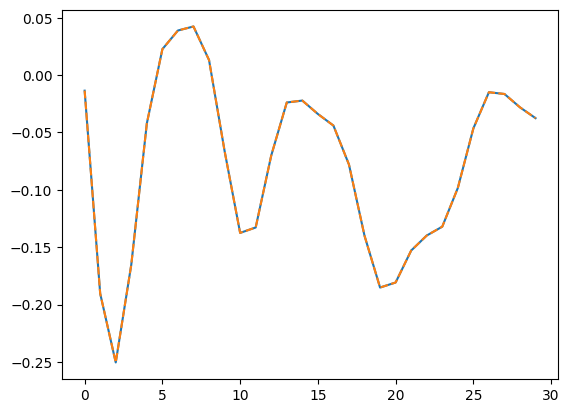

In [64]:
import matplotlib.pyplot as plt

# plt.plot(m_ivp[:,0,0],'.')
plt.plot(states[:,0,1])
# plt.plot(m_qutip[0,0,:,0],'.')
plt.plot(np.array(state_qutip)[:,1],'--')

In [36]:
np.array(m_qso).shape

(370, 1, 5)